In [122]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

# Inventory management - Luiza Labs

Esse case tem o objetivo de fazer uma análise exploratória dos dados de vendas da Magazine Luiza para aprender sobre o comportamento do processo de inventário da empresa.

Os dados são referentes ao período de junho de 2016 a junho de 2017 e originalmente estavam em formato csv.

O relatório abaixo se divide em 7 etapas:
1. Preparação da base de dados
2. Quantidades vendidas ao longo do tempo
3. Receita ao longo do tempo
4. Categorias de produtos vendidos ao longo do tempo
5. Curva ABC
6. Market basket analysis
7. Source channel


# 1. Preparação da base

In [3]:
inventory = pd.read_csv('desafio.csv', sep=',')
inventory.head()

,order_id,code,quantity,price,pis_cofins,icms,tax_substitution,category,liquid_cost,order_status,capture_date,process_date,process_status,source_channel
0,bcb59c839e78b2601374cbad9239ca7b,e6762ba2ffbca07ab6cee7551caeaad5,1,978.90,90.5483,0.0000,191.8416,4ece547755cba9e7fc14125bc895f31b,542.7065,entrega total,2016-06-11,2016-06-11,processado,b76eb9b8fc0f17098812da9117d3e500
1,4e91ee6b95895771dc9ee524e910a902,e6762ba2ffbca07ab6cee7551caeaad5,1,1036.29,95.8568,176.1693,0.0000,4ece547755cba9e7fc14125bc895f31b,542.7065,em rota de entrega,2016-06-11,2016-06-11,processado,b76eb9b8fc0f17098812da9117d3e500
2,88eb0ac86af1a521c0831298d22dea8b,e6762ba2ffbca07ab6cee7551caeaad5,1,978.90,90.5483,0.0000,191.8416,4ece547755cba9e7fc14125bc895f31b,542.7065,entrega total,2016-06-12,2016-06-12,processado,b76eb9b8fc0f17098812da9117d3e500
3,dee418152a36314b4aee6ce9cf94fcbf,e6762ba2ffbca07ab6cee7551caeaad5,1,978.90,90.5483,176.2020,0.0000,4ece547755cba9e7fc14125bc895f31b,542.7065,cancelado,2016-06-13,0000-00-00,captado,b76eb9b8fc0f17098812da9117d3e500
4,1c175bc61b9b659bbf011b2e5e3dcec6,e6762ba2ffbca07ab6cee7551caeaad5,1,976.05,90.2846,0.0000,192.3325,4ece547755cba9e7fc14125bc895f31b,542.7065,entrega total,2016-06-13,2016-06-13,processado,b76eb9b8fc0f17098812da9117d3e500


In [4]:
inventory.shape

(179149, 14)

In [5]:
inventory.dtypes

order_id             object
code                 object
quantity              int64
price               float64
pis_cofins          float64
icms                float64
tax_substitution    float64
category             object
liquid_cost         float64
order_status         object
capture_date         object
process_date         object
process_status       object
source_channel       object
dtype: object

# 2. Quantidades vendidas ao longo do tempo

Ao observar a quantidade de itens vendidos ao longo do tempo, é possível observar o comportamento das vendas no período de um ano.
Os gráficos abaixo mostram dois picos de venda: um ao final de novembro (provavelmente devido à black friday) e um no início de janeiro (provavelmente por causa das ofertas de início de ano.

Além disso, alguns meses possuem picos de venda na segunda semana: julho, setembro e março. Com mais informações, seria interessante buscar algum tipo de padrão sobre esses picos.

A decomposição dos dados em busca de tendência, sazonalidade e resíduo confirma que os picos em novembro e janeiro realmente são sazonais e que não há um ciclo de sazonalidade a curto prazo.

In [6]:
inventory['capture_date'] = pd.to_datetime(inventory['capture_date'])

In [160]:
time_series = inventory.groupby('capture_date').sum()
time_series.head()

,quantity,price,pis_cofins,icms,tax_substitution,liquid_cost
capture_date,,,,,,
2016-06-01,241,65256.84,5411.5549,7420.9539,4381.9576,34417.9901
2016-06-02,274,75015.49,6100.1734,7663.8320,5991.5966,39485.6783
2016-06-03,364,89428.76,6887.3414,8487.6894,7738.9364,50782.9449
2016-06-04,251,57175.48,4993.4262,4972.9749,5503.5441,32166.1116
2016-06-05,242,66707.14,5665.5379,5737.3290,6567.0296,38019.4587


In [29]:
sns.set(rc={'figure.figsize':(11, 4)})

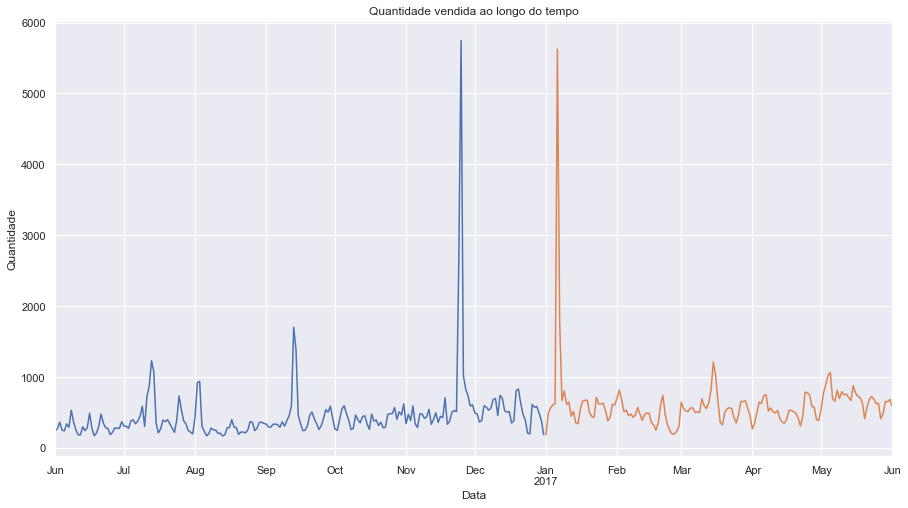

In [196]:
anos = ['2016', '2017']
for ano in anos:
    anual = time_series.loc[ano, 'quantity'].plot()
    anual.set_ylabel('Quantidade');
    anual.set_xlabel('Data');
    anual.set_title('Quantidade vendida ao longo do tempo')

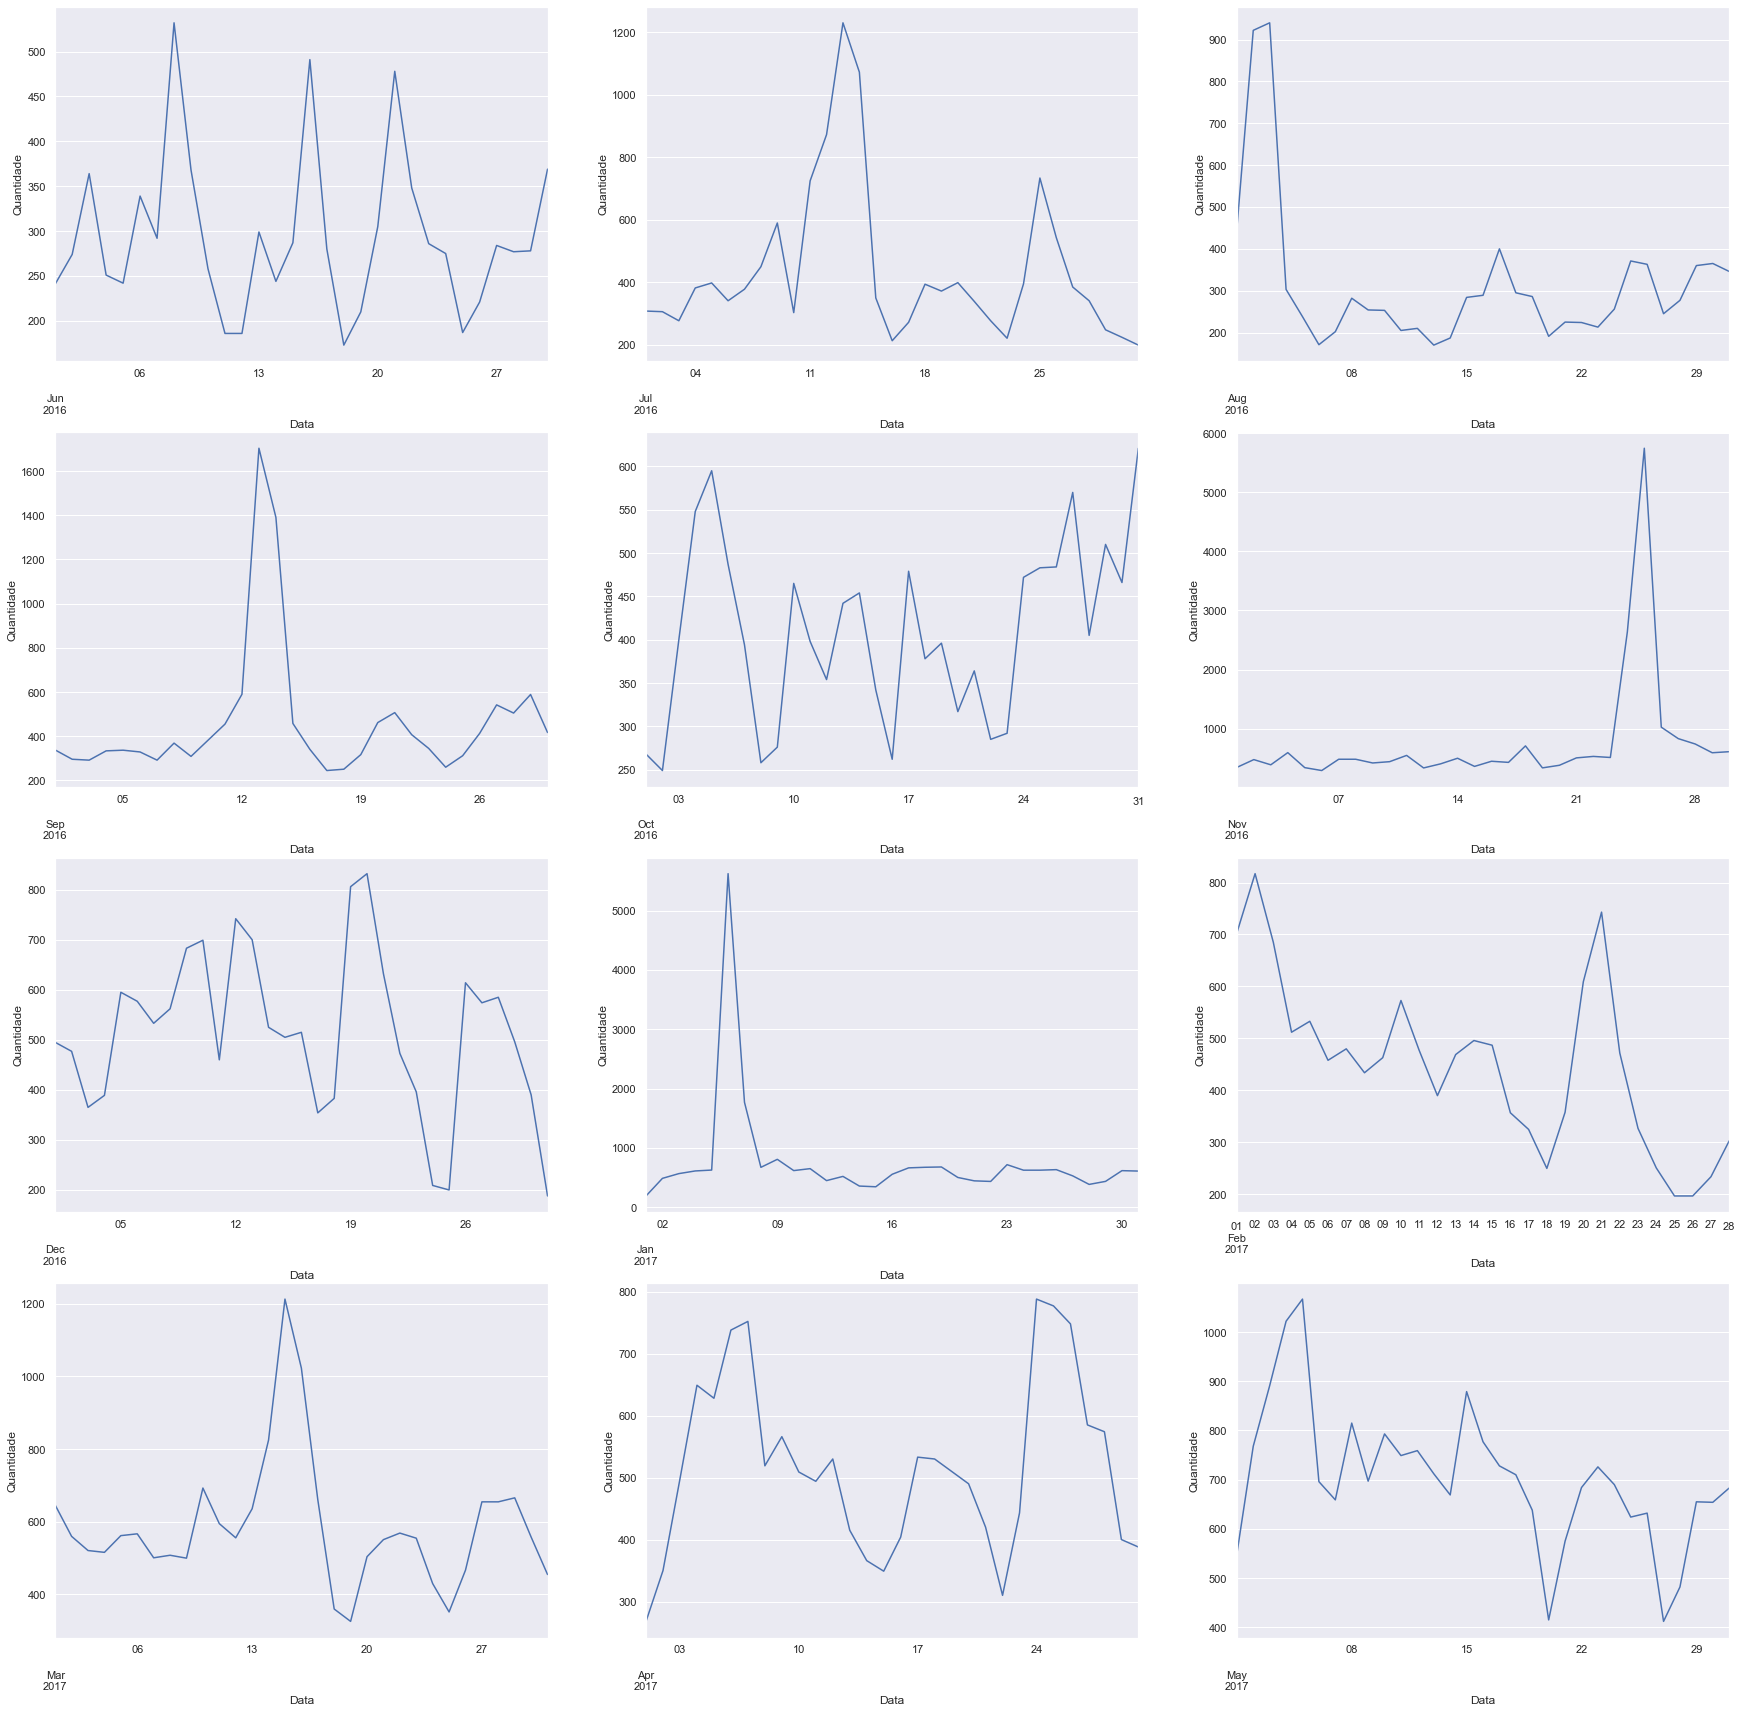

In [200]:
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
years = ['2016', '2017']
y = [0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2]
x = [0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3]
contador = 0

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(30,30))
for year in years:
    for month in months:
        try:
            mes = time_series.loc['{}-{}'.format(year, month), 'quantity'].plot(ax=axes[x[contador], y[contador]])
            mes.set_ylabel('Quantidade');
            mes.set_xlabel('Data');
            contador += 1
        except:
            pass

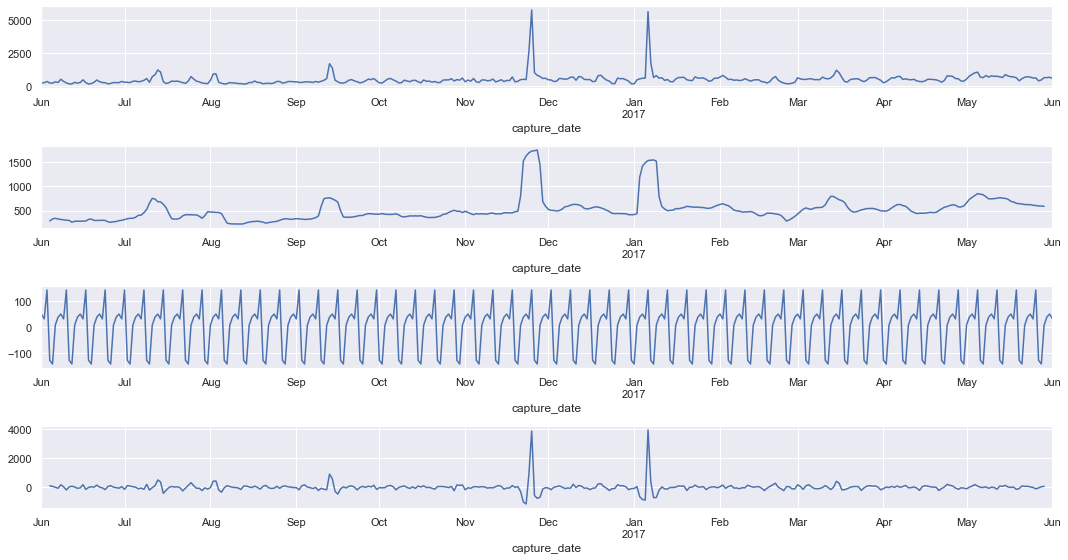

In [32]:
from statsmodels.tsa.seasonal import seasonal_decompose
time_series_season = time_series.loc[:, ['quantity']]
seasonplot = seasonal_decompose(time_series_season)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15,8))
seasonplot.observed.plot(ax=ax1)
seasonplot.trend.plot(ax=ax2)
seasonplot.seasonal.plot(ax=ax3)
seasonplot.resid.plot(ax=ax4)
plt.tight_layout()

# 3. Receita ao longo do tempo

O gráfico abaixo mostra o comportamento da receita bruta e da receita líquida ao longo do tempo. Os picos de venda no final de novembro e no início de janeiro realmente geram um pico de receita nesses períodos. Além disso, nesses picos, a receita líquida é significativamente menor que a receita bruta, sinalizando que os produtos provavelmente possuem um custo considerável. 
No tópico abaixo, observa-se que esses picos de venda são referentes a venda de uma categoria específica de produtos, sobre a qual incidem mais taxas e impostos que em outras categorias. Esse comportamento pode explicar porque a diferença entre a receita bruta e a líquida nesses dois picos.

<AxesSubplot:title={'center':'Receita bruta e líquida ao longo do tempo'}, xlabel='Data'>

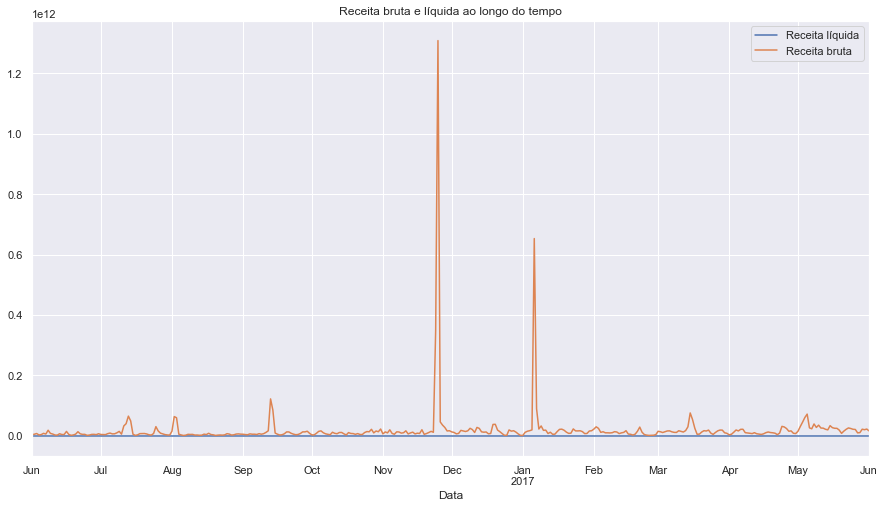

In [194]:
rendimento_por_tempo = (time_series['quantity'] * time_series['price']) - (time_series['quantity'] * time_series['liquid_cost'])
rendimento_por_tempo.plot(legend=True, label='Receita líquida')
vendas_por_tempo = time_series['price'] * time_series['price']
vendas_por_tempo.plot(legend=True, label='Receita bruta', title='Receita bruta e líquida ao longo do tempo', xlabel='Data')

# 4. Quantidade de produtos vendidos ao longo do tempo por categoria

O gráfico abaixo mostra que uma categoria de produtos claramente se sobrepõe às outras. Além disso, os picos de venda no final de novembro e no início de janeiro, em grande parte, se dão pela venda dessa categoria específica de produtos.

In [192]:
rendimento_por_tempo

capture_date
2016-06-01    7.432163e+06
2016-06-02    9.735168e+06
2016-06-03    1.406708e+07
2016-06-04    6.277351e+06
2016-06-05    6.942419e+06
                  ...     
2017-05-28    2.295554e+07
2017-05-29    4.479070e+07
2017-05-30    4.265247e+07
2017-05-31    4.704991e+07
2017-06-01    3.548565e+07
Length: 366, dtype: float64

In [162]:
categories_sum = inventory.groupby('category').sum()
categories_sum.head()

,quantity,price,pis_cofins,icms,tax_substitution,liquid_cost
category,,,,,,
388128822cef4b4f102ae881e040a64b,161141,3.452563e+07,3.185098e+06,3.632682e+06,2.647979e+06,1.996506e+07
4ece547755cba9e7fc14125bc895f31b,64,5.423365e+04,5.016614e+03,5.695878e+03,4.733052e+03,3.098149e+04
568696c0b6828f77884ea8628fcc6200,71,5.998456e+04,5.548572e+03,1.037559e+04,0.000000e+00,3.401698e+04
61ad270def6d4b2403f4536f39cff29a,203,5.278710e+03,4.832442e+02,9.511344e+02,0.000000e+00,2.572440e+03
90cc5bdd050bcd7cf0d50d079d0fda66,5791,2.880970e+06,2.656962e+05,2.868938e+05,2.310577e+05,1.712917e+06


Text(0.5, 1.0, 'Quantidade vendida por categoria')

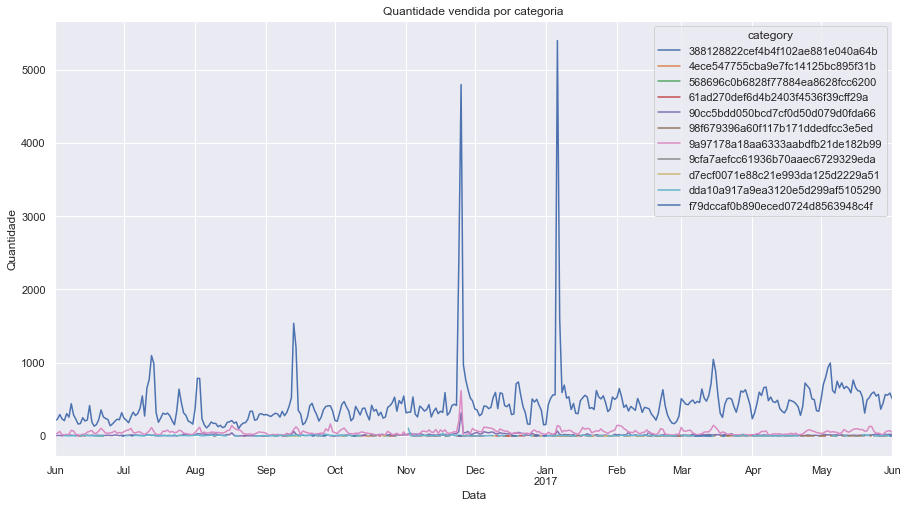

In [70]:
sns.set(rc={'figure.figsize':(15, 8)})
df = inventory.loc[:, ('capture_date', 'quantity', 'category')]
df_grouped = df.groupby(["capture_date", "category"]).agg(sum_qtd=("quantity", "sum")).reset_index()

df_pivot = df_grouped.pivot(index="capture_date", columns="category", values="sum_qtd").reset_index()

ax = df_pivot.plot(x="capture_date", xlabel="Data", ylabel="Quantidade")
ax.set_title("Quantidade vendida por categoria")

Text(0, 0.5, 'Soma de taxas e impostos')

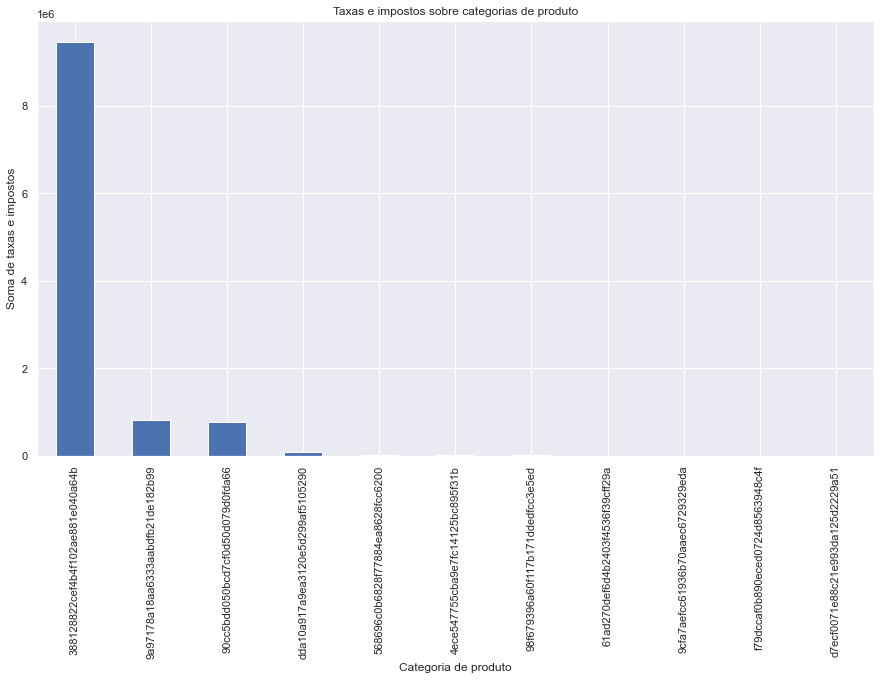

In [203]:
taxes_agg = categories_sum['pis_cofins'] + categories_sum['icms'] + categories_sum['tax_substitution']
taxes = taxes_agg.sort_values(ascending=False).plot.bar()
taxes.set_title('Taxas e impostos sobre categorias de produto')
taxes.set_xlabel('Categoria de produto')
taxes.set_ylabel('Soma de taxas e impostos')

# 5. Curva ABC

Esse método de classificação é muito útil para definir grupos de produtos que mais vendem e, assim, planejar um gerenciamento de inventário mais controlado para esses produtos.

A classificação divide os produtos em 3 grupos e aqui se utilizou os seguintes critérios:
Grupo A: produtos que representam 80% da receita anual acumulada e representam cerca de 23% dos produtos do inventário.
Grupo B: produtos que representam 15% de um ano de venda e 33% dos produtos do inventário.
Grupo C: são os produtos que somados representam 5% da receita anual e nesse caso são 44% dos produtos do inventário.

Os produtos do grupo A são os "bestsellers" da empresa. Aqui, plotei um gráfico com os cinco produtos mais vendidos do grupo A e a receita gerada por eles.

Da mesma forma, plotei um gráfico com os cinco produtos mais vendidos do grupo B, que também são interessantes de ser observados. Seria possível procurar levar esses produtos para o grupo A.

Por fim, o terceiro gráfico desse tópico mostra os cinco produtos que geraram menos receita no ano analisado. Esses produtos podem ser melhor analisados para planejar uma estratégia de crescimento de vendas.

In [39]:
vendas_produtos = inventory.groupby('code').sum().sort_values("price", ascending=False)

In [40]:
total_vendas_produtos = vendas_produtos['price'].sum()

42035267.87000018

In [41]:
vendas_produtos['cumulative'] = vendas_produtos['price'].cumsum(skipna = True)

In [54]:
e_percent = total_vendas_produtos * 0.8
group_a = vendas_produtos[(vendas_produtos.cumulative <= e_percent)]
group_a.head()

,quantity,price,pis_cofins,icms,tax_substitution,liquid_cost,cumulative
code,,,,,,,
2e35421c34fb588ba40a0c57b3971d24,21723,7.196087e+06,663287.0113,697317.6400,681652.9478,4.470250e+06,7.196087e+06
4534ea61b50410b3b6243e02b40c8cd1,18896,3.436322e+06,0.0000,420605.9879,253111.5242,2.058499e+06,1.063241e+07
32ceebf3efea1d04ace4183d20d4da5b,9085,3.083203e+06,284877.8304,316116.0654,274467.0116,1.830242e+06,1.371561e+07
3454ea52396a4cfd3fc37414d30c7b9c,11211,2.136580e+06,196157.8676,212288.5795,148951.4297,1.124567e+06,1.585219e+07
760693745e10b0c5e68c42214c729b0d,5034,1.683410e+06,155453.4016,230550.4004,77173.2914,1.001702e+06,1.753560e+07


Text(0.5, 1.0, 'Produtos bestsellers')

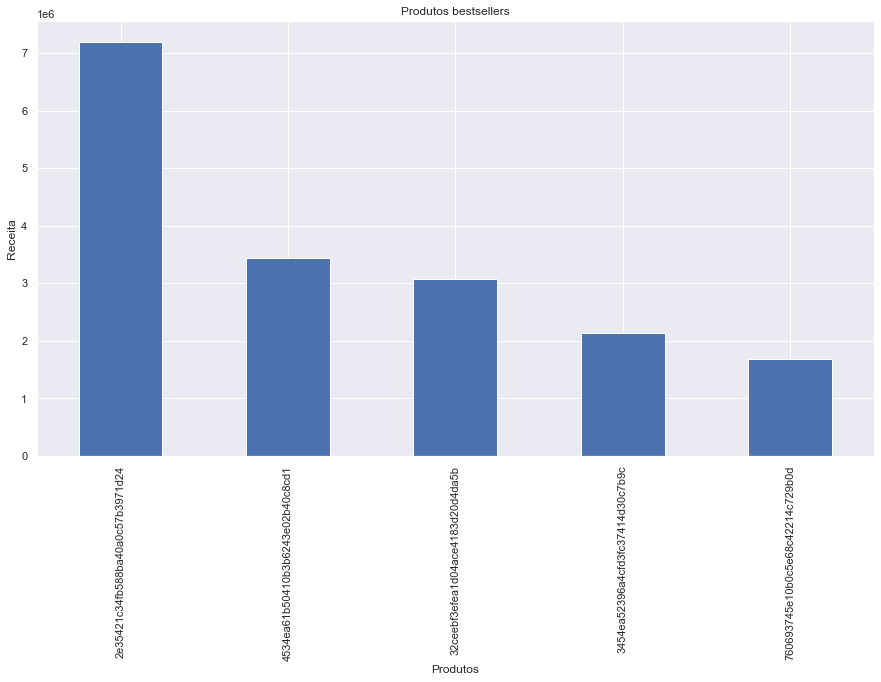

In [146]:
top_group_a = group_a.head()
bar_graph_a = top_group_a.reset_index().plot.bar(x='code', y='price', legend=False, xlabel="Produtos", ylabel="Receita")
bar_graph_a.set_title("Produtos bestsellers")

Grupo B

In [182]:
n_percent = total_vendas_produtos * 0.95
group_b = vendas_produtos[((vendas_produtos.cumulative <= f_percent) & (vendas_produtos.cumulative > e_percent))]
group_b.head()

,quantity,price,pis_cofins,icms,tax_substitution,liquid_cost,cumulative
code,,,,,,,
e13f7f001fe2b1af072a3d50d3058284,1979,260861.68,24134.6074,20865.4550,24486.1286,129889.7166,33822020.27
b9d929195dcd4e6a36e5e65891746b5e,588,260395.75,24045.8953,27987.1279,22708.1472,123137.9092,34082416.02
a586c072b4a3958ac72a6fff71730cb3,1454,259593.33,23963.0812,25977.9228,17905.6887,116727.2700,34342009.35
ffdad3ddbaf6c76c9bba1b48c51e03c6,1142,238538.52,22041.2067,14756.6846,25349.5196,138112.2813,34580547.87
5837d4e32e5382af65d33b4dfbd9f561,716,227281.23,20989.1349,14889.3719,27869.0478,130809.6900,34807829.10


Text(0.5, 1.0, 'Produtos do grupo B')

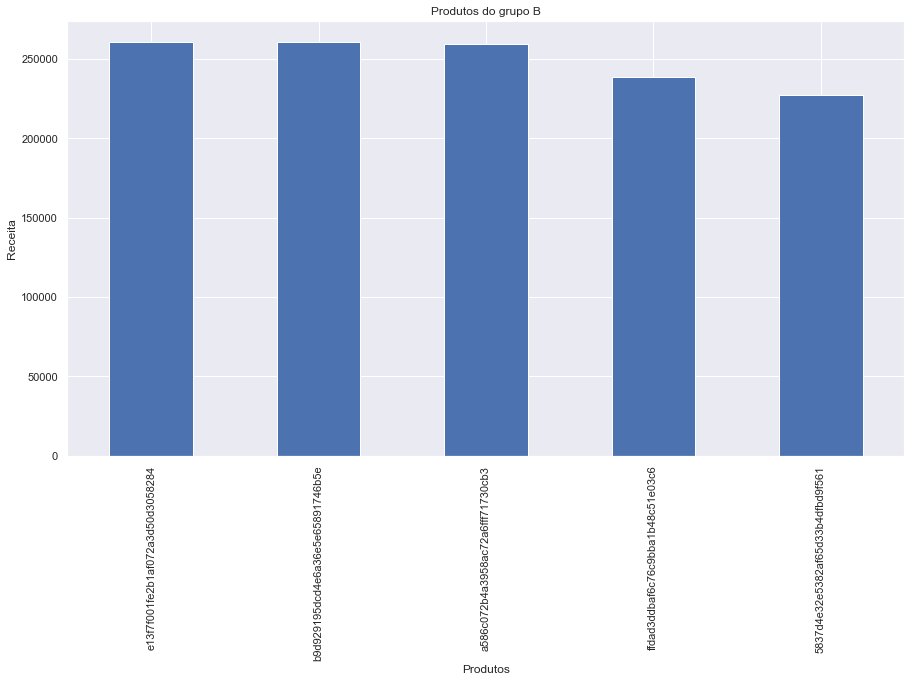

In [145]:
top_group_b = group_b.head()
bar_graph_b = top_group_b.reset_index().plot.bar(x='code', y='price', legend=False, xlabel="Produtos", ylabel="Receita")
bar_graph_b.set_title("Produtos do grupo B")

Grupo C

In [178]:
group_c = vendas_produtos[(vendas_produtos.cumulative > n_percent)].sort_values('price', ascending=True)
group_c.head()

,quantity,price,pis_cofins,icms,tax_substitution,liquid_cost,cumulative
code,,,,,,,
2bc9e1d807d8f9187b8650acd35a14e5,3,145.11,13.4227,26.3074,0.0000,53.6274,42035267.87
630b051b117d509fc00a7c72328b1ddf,7,200.18,18.5167,17.3305,8.2302,47.2192,42035122.76
3b4407288e2983a514a241c9b84b7094,11,332.88,28.5493,55.2049,0.0000,112.9755,42034922.58
7c829a5a8a0e4408b682f4394783483e,140,1074.91,99.4321,69.3527,9.5820,575.9740,42034589.70
41e2bee39c1d3ef52fcedd69d0ab8c8c,61,2509.36,233.2337,319.7917,144.9840,982.9459,42033514.79


Text(0.5, 1.0, 'Produtos que geram menos receita')

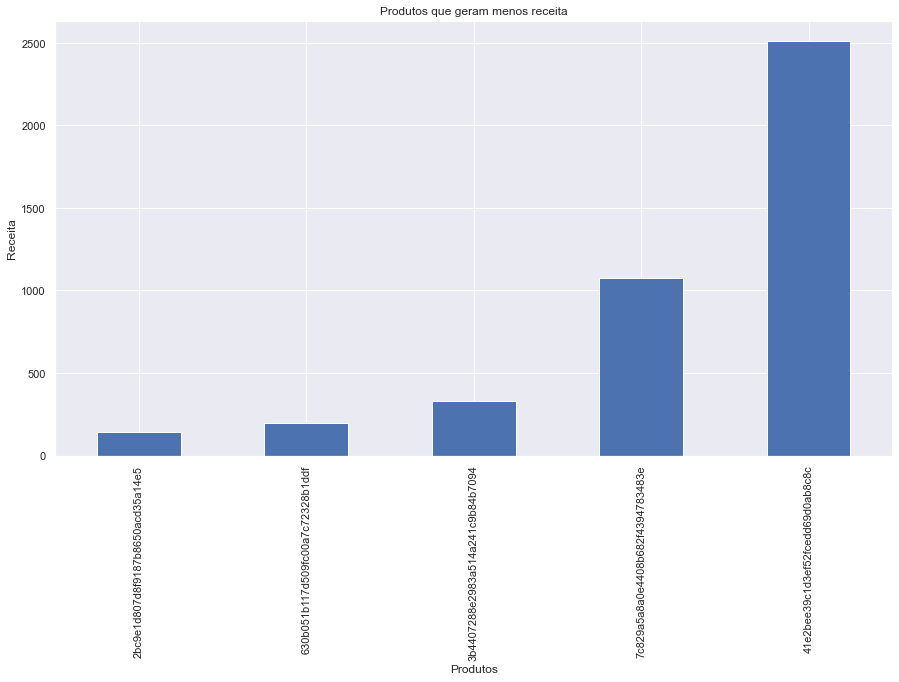

In [179]:
asc_group_c = group_c.head()
bar_graph_c = asc_group_c.reset_index().plot.bar(x='code', y='price', legend=False, xlabel="Produtos", ylabel="Receita")
bar_graph_c.set_title("Produtos que geram menos receita")

# 6. Market basket analysis

A análise de cesta de compras tem o objetivo de mostrar quais itens geralmente são comprados juntos.

A média de itens por compra do inventário é de 1 produto e o histograma mostra que o número de vendas com apenas 1 item é muito maior que o número de vendas com mais de um item. O resultado é que geralmente compra-se apenas 1 item por compra. A análise de cesta de compras pode ajudar a aumentar o número de itens por compra e, consequentemente, a receita de vendas. Ao saber quais itens geralmente são comprados juntos, é possível recomendar o produto B sempre que o produto A entrar no carrinho de compras.

O gráfico de barra mostra as 10 combinações de pedidos mais frequentes, o que quer dizer que pessoas que compram um dos itens da combinação tem mais chances de também comprar o outro item. Em uma análise mais detalhada, é possível realizar uma estratégia de venda de itens combinados para aumentar a receita de vendas.


Média de itens por compra

In [117]:
quantidade_itens = inventory[['order_id', 'quantity']].groupby(['order_id', 'quantity']).count().reset_index().sort_values("quantity", ascending=False)
quantidade_itens['quantity'].mean()

count    175785.000000
mean          1.055716
std           0.602017
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         100.000000
Name: quantity, dtype: float64

In [ ]:
Distribuição do número de itens por compra

Text(0.5, 0, 'Número de itens por compra')

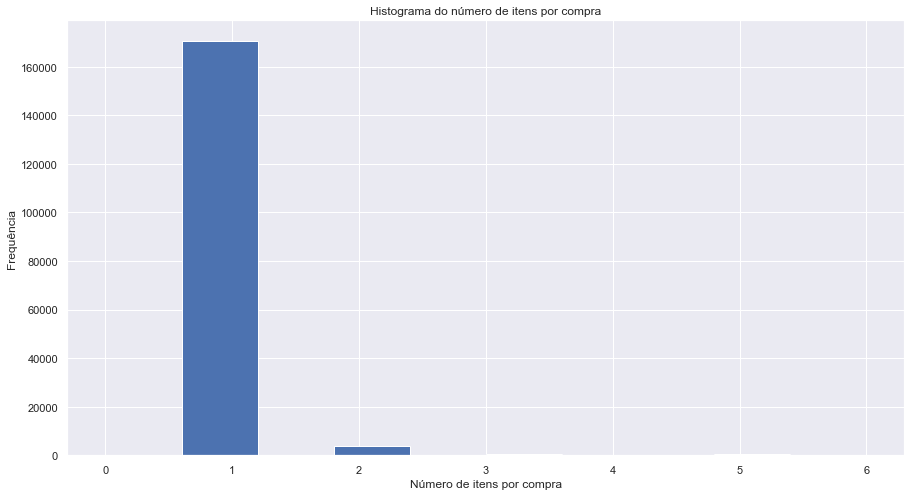

In [205]:
quantidade_itens['quantity'].plot(kind='hist', legend=False, range=[0, 6])
plt.title('Histograma do número de itens por compra')
plt.ylabel('Frequência')
plt.xlabel('Número de itens por compra')

In [119]:
items = inventory.groupby(['order_id', 'capture_date']).agg({'code': lambda x: x.ravel().tolist()}).reset_index()
items.head()

,order_id,capture_date,code
0,00000964d969d9313a33cd1df8fa4604,2017-04-08,[42920a6f15855662ee9a272fbe44cbd1]
1,00005f76305473c23cfb2a202a3da5e9,2016-12-16,[3454ea52396a4cfd3fc37414d30c7b9c]
2,000190c81ee107511f72f56e58ca3923,2017-01-06,[1f12f1e1b9e7a20d4ad9dd549ec072c0]
3,0001b49c252907291ca16195773ef104,2016-12-21,[c254dc11afbcc091678f0ab49a02e7ad]
4,00022b661f9f7dad8cea54151ef601f1,2016-12-30,[4534ea61b50410b3b6243e02b40c8cd1]


In [125]:
combinations_list = []
for row in items.code:
    combinations = list(itertools.combinations(row, 2))
    combinations_list.append(combinations)

for combination in combinations_list:
    if len(combination) == 0:
        combinations_list.remove(combination)

Top 10 combinações de itens mais frequentes

In [188]:
combination_counts = pd.Series(combinations_list).explode().reset_index(drop=True)

<AxesSubplot:title={'center':'Top 10 combinações de itens mais frequentes'}, ylabel='Combinações de itens'>

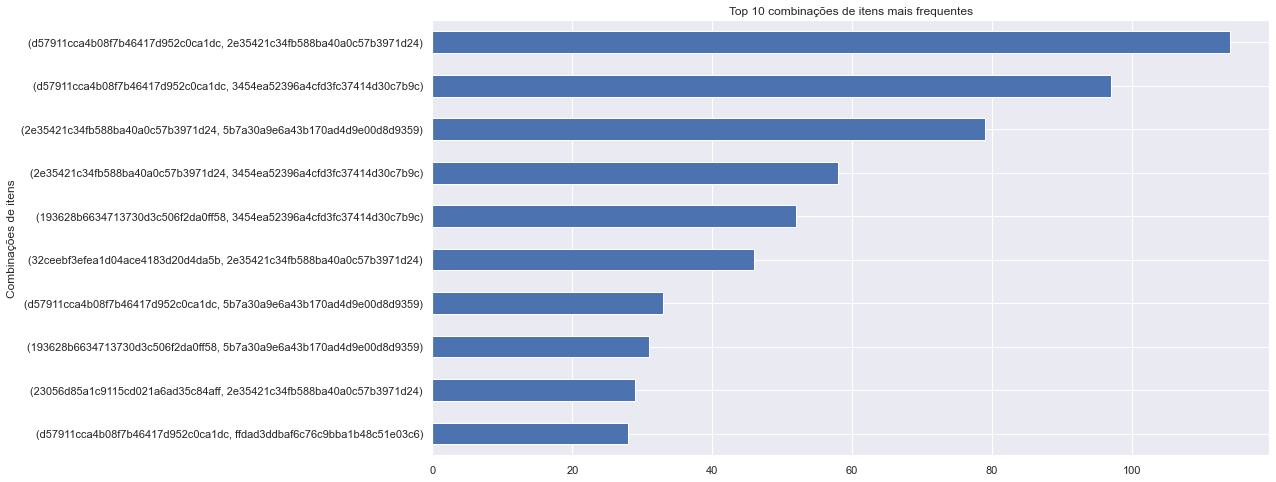

In [211]:
combination_counts.value_counts()[:10].sort_values(ascending=True).plot.barh(title='Top 10 combinações de itens mais frequentes', ylabel='Combinações de itens')

In [156]:
quantidade_produtos = inventory.groupby('code').count()
quantidade_produtos['quantity']
# quantas vezes o item aparece
# quantas vezes aparece em combinação
# probabilidade de comprar outro se comprar esse

code
0671c2b9132a3f5215a4212ce0691694    6496
09f544ec2a74c89abeec7b0590fc2d11     978
0ad316f6b5cb5e81ebff73ae2490ccfe     489
0bbe09e34a11e8e31cf49d6f8df2992d     341
0dca7ec6ba9b6e8f17f04f713a6be727     932
                                    ... 
f08984b2adcbf33ba61fe13fcfa5b957     424
f5f92c2a12f182115c45288a6ef28e94     485
f9a023f31c8087fd0c169b3bedd351d1     691
fd84644da59504bd9e9dcb4b6db63bea    2917
ffdad3ddbaf6c76c9bba1b48c51e03c6    1113
Name: quantity, Length: 131, dtype: int64

# 7. Source channel

Nesse tópico, mostra-se o número de pedidos por canal de compra. Assim, é possível saber quais canais concentram o maior número de pedidos e quais precisam de estratégias especiais para aumentar os números.

Text(0.5, 0, 'Canal de venda')

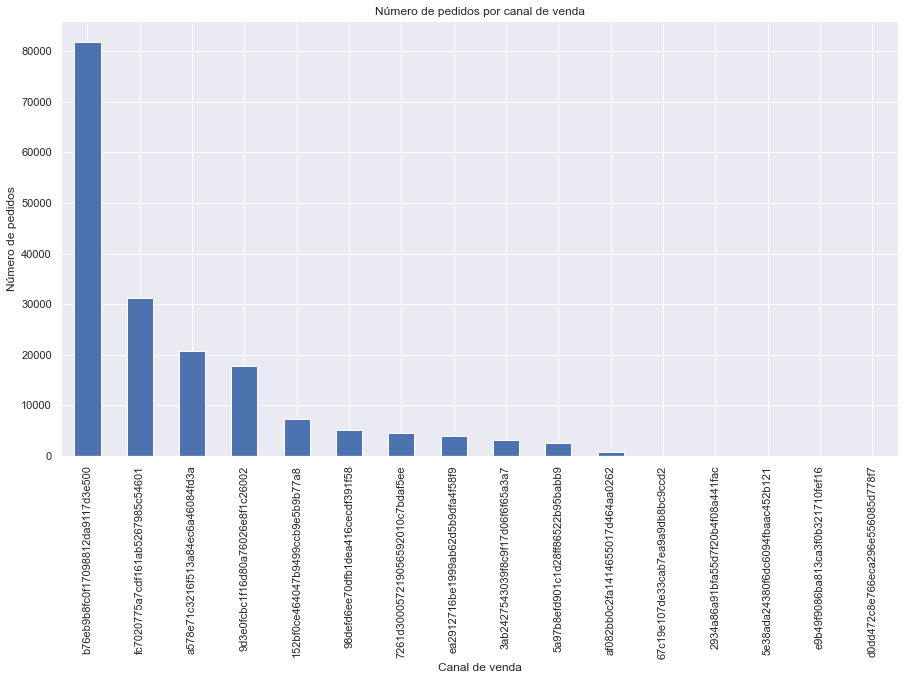

In [213]:
source = inventory.groupby('source_channel')['order_id'].count().sort_values(ascending=False).plot.bar()
source.set_title('Número de pedidos por canal de venda')
source.set_ylabel('Número de pedidos')
source.set_xlabel('Canal de venda')

# Referências

https://imasters.com.br/data/series-temporais-e-componentes-aplicando-arima-para-forecast-em-dados-do-covid-19

https://insidebigdata.com/2018/10/18/predictive-analytics-used-inventory-management/

https://nrsplus.com/blog/small-business-inventory-management/

https://risnews.com/say-goodbye-inventory-challenges-predictive-analytics

https://towardsdatascience.com/market-basket-analysis-with-pandas-246fb8ee10a5